## Movie Recommendation System for Turner Classic Movies

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV

In [149]:
#links_df = pd.read_csv('data/ml-25m/ml-25m/links.csv')
movies_df = pd.read_csv('data/ml-25m/ml-25m/movies.csv')
ratings_df = pd.read_csv('data/ml-25m/ml-25m/ratings.csv')
#tags_df = pd.read_csv('data/ml-25m/ml-25m/tags.csv')
#genome_scores_df = pd.read_csv('data/ml-25m/ml-25m/genome-scores.csv')
#genome_tags_df = pd.read_csv('data/ml-25m/ml-25m/genome-tags.csv')

In [150]:
#links_df.head()

In [151]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [152]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [153]:
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)')

In [154]:
movies_df

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001


In [155]:
movies_df['year'].isna().sum()

410

In [156]:
movies_df = movies_df.dropna(subset=['year'])

In [157]:
movies_df['year'].isna().sum()

0

In [158]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62013 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62013 non-null  int64 
 1   title    62013 non-null  object
 2   genres   62013 non-null  object
 3   year     62013 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [159]:
movies_df_old = movies_df.copy()

In [160]:
movies_df_old['year'] = movies_df_old['year'].astype(int)

In [161]:
movies_df_clean = movies_df_old[movies_df_old['year'] <= 1969]

In [162]:
movies_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12049 entries, 152 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  12049 non-null  int64 
 1   title    12049 non-null  object
 2   genres   12049 non-null  object
 3   year     12049 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 423.6+ KB


In [163]:
movies_df_final = movies_df_clean.drop('year', axis=1)

In [164]:
movies_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12049 entries, 152 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  12049 non-null  int64 
 1   title    12049 non-null  object
 2   genres   12049 non-null  object
dtypes: int64(1), object(2)
memory usage: 376.5+ KB


In [165]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [166]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [167]:
ratings_df_clean = ratings_df.drop(columns='timestamp')

In [168]:
ratings_df_clean.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [169]:
ratings_df_final = ratings_df_clean[ratings_df_clean['movieId'].isin(movies_df_final['movieId'])]

In [170]:
ratings_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770686 entries, 4 to 25000019
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 54.0 MB


In [171]:
#tags_df.head()

In [172]:
#tags_df.info()

In [173]:
#tags_df_clean = tags_df.drop(columns='timestamp')

In [174]:
#tags_df_clean.head()

In [175]:
#tags_df_clean['tag'].value_counts()['classic']

In [176]:
#genome_scores_df.info()

In [177]:
#genome_scores_df.head()

In [178]:
#genome_tags_df.head()

In [179]:
#genome_tags_df.info()

EDA Graphs

In [180]:
movies_df_final.reset_index(inplace=True, drop=True)

In [181]:
movies_df_final

,movieId,title,genres
0,154,Beauty of the Day (Belle de jour) (1967),Drama
1,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical|Romance
2,390,Faster Pussycat! Kill! Kill! (1965),Action|Crime|Drama
3,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical
4,596,Pinocchio (1940),Animation|Children|Fantasy|Musical
...,...,...,...
12044,209089,An Impossible Balancing Feat (1902),(no genres listed)
12045,209137,The Reward's Yours... The Man's Mine (1969),Western
12046,209139,Rimsky-Korsakov (1953),Drama
12047,209147,The Carpet of Horror (1962),Crime|Horror


In [182]:
ratings_df_final.reset_index(inplace=True, drop=True)

In [183]:
ratings_df_final

,userId,movieId,rating
0,1,899,3.5
1,1,1237,5.0
2,1,1250,4.0
3,1,1260,3.5
4,1,2351,4.5
...,...,...,...
1770681,162541,969,4.0
1770682,162541,1029,3.5
1770683,162541,1201,3.0
1770684,162541,2080,4.0


In [184]:
movies_and_ratings_df = pd.merge(movies_df_final, ratings_df_final, on='movieId', how='right')

In [185]:
movies_and_ratings_df

,movieId,title,genres,userId,rating
0,899,Singin' in the Rain (1952),Comedy|Musical|Romance,1,3.5
1,899,Singin' in the Rain (1952),Comedy|Musical|Romance,31,4.0
2,899,Singin' in the Rain (1952),Comedy|Musical|Romance,58,5.0
3,899,Singin' in the Rain (1952),Comedy|Musical|Romance,59,3.5
4,899,Singin' in the Rain (1952),Comedy|Musical|Romance,72,5.0
...,...,...,...,...,...
1770681,117644,Dr. Socrates (1935),Crime|Drama|Romance,162047,3.5
1770682,123425,The Last Gangster (1937),Crime|Drama|Thriller,162047,3.0
1770683,131211,Copper Canyon (1950),Action|Western,162047,3.0
1770684,151050,The Burning Court (1962),Drama|Horror|Mystery|Thriller,162047,4.0


Graph most popular movies by number of ratings, average rating

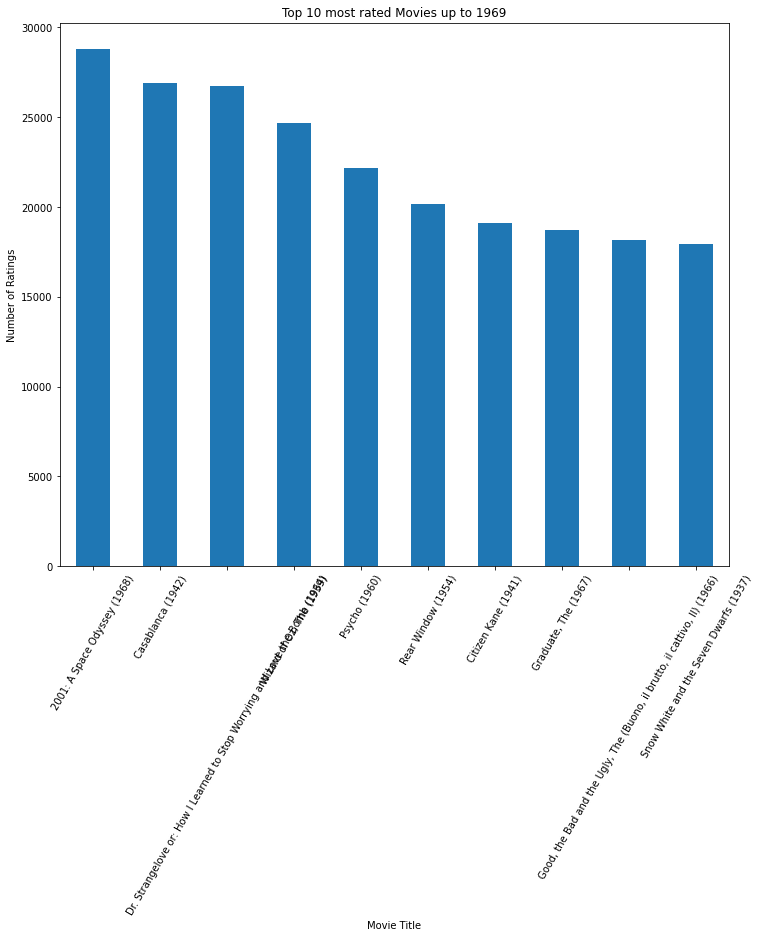

In [186]:
movies_and_ratings_df['title'].value_counts(sort=True).head(10).plot(
    figsize = (12, 10),
    kind = 'bar',
    title = 'Top 10 most rated Movies up to 1969',
    ylabel = 'Number of Ratings',
    xlabel = 'Movie Title',
    );
plt.xticks(rotation=60);

These Movies might have an effect on modeling because of their number of reviews.

<Axes: title={'center': 'Top Ten Highest Rated Movies up to 1969'}, xlabel='title'>

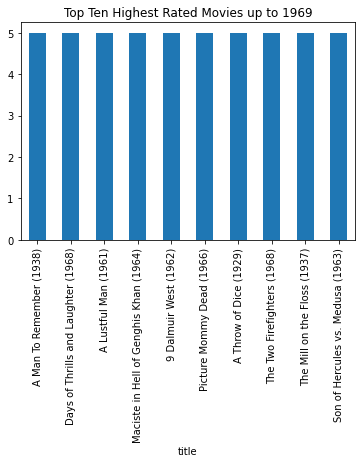

In [187]:
movies_and_ratings_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10).plot(
    kind='bar',
    title='Top Ten Highest Rated Movies up to 1969',)

Doesn't really say much because these movies might only have 1 5 star rating.

# Modeling

In [188]:
ratings_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770686 entries, 0 to 1770685
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 40.5 MB


In [189]:
ratings_df_modeling = ratings_df_final.copy()

In [190]:
ratings_df_modeling['rating'] = ratings_df_modeling['rating'].astype(np.float32)

In [197]:
ratings_df_modeling['userId'] = ratings_df_modeling['userId'].astype(np.int32)

In [199]:
ratings_df_modeling['movieId'] = ratings_df_modeling['movieId'].astype(np.int32)

In [200]:
ratings_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770686 entries, 0 to 1770685
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 20.3 MB


In [201]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df_modeling, reader)

In [202]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  108348 

Number of items:  10498


More efficient to item-item similarity because there are less items than users.

Baseline KNN Model with pearson correlation and item-item similarity.

In [203]:
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':False})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [204]:
print(np.mean(cv_knn_basic['test_rmse']))
print(np.mean(cv_knn_basic['test_mae']))

0.8182437123389592
0.6151144779192409


Baseline model with no hyperparameter tuning has cross-validation RMSE of .818 and MAE of .615

In [209]:
#Gridsearch KNN Model to see best params for KNN
params = {'k': [30, 40, 50],
         'sim_options': {'name':['cosine', 'pearson', 'pearson_baseline']}
         }
KNNBasic_gridsearch = GridSearchCV(KNNBasic, param_grid = params, cv = 5)
KNNBasic_gridsearch.fit(data)

Computing the cosine similarity matrix...


MemoryError: Unable to allocate 40.1 GiB for an array with shape (103757, 103757) and data type int32

In [210]:
## Gridsearch with SVD
params = {'n_factors': [20, 50, 100],
          'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd.fit(data)

In [211]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.7848898342957987, 'mae': 0.6016915689111969}
{'rmse': {'n_factors': 50, 'reg_all': 0.02}, 'mae': {'n_factors': 50, 'reg_all': 0.02}}


In [213]:
params = {'n_factors': [40, 50, 60],
          'reg_all': [0.01, 0.02, 0.03],
          'lr_all': [0.005, 0.01]}
g_s_svd2 = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd2.fit(data)

In [214]:
print(g_s_svd2.best_score)
print(g_s_svd2.best_params)

{'rmse': 0.7759011835818349, 'mae': 0.5926221927274794}
{'rmse': {'n_factors': 50, 'reg_all': 0.03, 'lr_all': 0.01}, 'mae': {'n_factors': 50, 'reg_all': 0.03, 'lr_all': 0.01}}


Baseline SVD model below

In [215]:
svd=SVD()
cv_svd = cross_validate(svd, data)

In [216]:
print(np.mean(cv_svd['test_rmse']))
print(np.mean(cv_svd['test_mae']))

0.7849326939458117
0.6013316857108723


SVD results from hyperparameter tuning and the model that will be used.

In [217]:
print(g_s_svd2.best_score)
print(g_s_svd2.best_params)

{'rmse': 0.7759011835818349, 'mae': 0.5926221927274794}
{'rmse': {'n_factors': 50, 'reg_all': 0.03, 'lr_all': 0.01}, 'mae': {'n_factors': 50, 'reg_all': 0.03, 'lr_all': 0.01}}


In [218]:
svd1 = SVD(n_factors=50, reg_all=0.03, lr_all=0.01)
svd1.fit(dataset)

In [219]:
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.932399478015329, details={'was_impossible': False})

In [220]:
def movie_rater(movies_df_final, num, genre=None):
    userID = 110000
    rating_list = []
    while num > 0:
        if genre:
            movie = movies_df_final[movies_df_final['genres'].str.contains(genre)].sample(1)
        else:
            movie = movies_df_final.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [ ]:
user_rating = movie_rater(movies_df_final, 5, 'Thriller')

      movieId               title                                      genres
2706    68411  Black Magic (1944)  Comedy|Crime|Drama|Horror|Mystery|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId            title          genres
6020   124194  The Risk (1960)  Drama|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId               title                    genres
5569   121993  Night Court (1932)  Crime|Film-Noir|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                title    genres
8921   157711  The 49th Man (1953)  Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId               title    genres
6172   124769  Stolen Face (1952)  Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
     movieId                                      title  

      movieId                            title  \
4937   115258  Charlie Chan in Honolulu (1938)   

                                    genres  
4937  Comedy|Crime|Horror|Mystery|Thriller  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                       title                genres
5549   121933  The Beat Generation (1959)  Crime|Drama|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId             title            genres
9411   163296  Moss Rose (1947)  Mystery|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                         title                     genres
2809    71102  Three Musketeers, The (1933)  Action|Adventure|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                       title    genres
8153   150206  Night Without Sleep (1952)  Thriller
How do you rate thi

How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                           title           genres
7674   145014  The House That Screamed (1969)  Horror|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                 title                genres
2053    36426  Black Dragons (1942)  Mystery|Thriller|War
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId            title          genres
7630   144780  Close-Up (1948)  Drama|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                        title          genres
2025    34065  Billion Dollar Brain (1967)  Drama|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId            title                        genres
4151    98394  Cry Wolf (1947)  Crime|Drama|Mystery|Thriller
How do you rate this movie on

##### Need to change this function to show the most reviewed movies by genre instead of random sample

In [229]:
user_rating

[{'userId': 110000, 'movieId': 129317, 'rating': '5'},
 {'userId': 110000, 'movieId': 4358, 'rating': '5'},
 {'userId': 110000, 'movieId': 115258, 'rating': '5'},
 {'userId': 110000, 'movieId': 137543, 'rating': '5'},
 {'userId': 110000, 'movieId': 85616, 'rating': '5'}]

In [230]:
user_ratings = pd.DataFrame(user_rating)
new_ratings_df = pd.concat([ratings_df_final, user_ratings], axis=0)
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [231]:
new_ratings_df

,userId,movieId,rating
0,1,899,3.5
1,1,1237,5
2,1,1250,4
3,1,1260,3.5
4,1,2351,4.5
...,...,...,...
0,110000,129317,5
1,110000,4358,5
2,110000,115258,5
3,110000,137543,5
